In [1]:
import numpy as np
from numpy import sin, pi, exp
import matplotlib.pyplot as plt
import xarray as xr
import gsw
import xgcm
import cmocean.cm as cmo

In [2]:
#constants through out this notebook
g=9.81
f=gsw.f(-65) 
alpha0=1e-4
rho0=1035

In [3]:
dr=np.array(50*np.ones(100))
np.sum(dr) 
dr.shape
len(dr)

nx = 60
ny = 40
nr = len(dr)
rF = (np.insert(np.cumsum(dr),0,0)) # z-coordinates of vertical cell faces
z = np.diff(rF)/2 + rF[:-1]         # z-coordinates of vertical cell centers
H = -np.sum(dr)  
print(H)
# bathymetry -- flat bottom of depth H (m) with idealized mid-depth ridge
bump_max = 3000.   # peak height of ridge above flat bottom depth
bathy = H * np.ones([ny, nx])
bump = np.zeros([ny, nx])
# gaussian bump in the center of domain
# horizontal resoluiton in km 25
dx=25
dy=25
X=np.arange(0,nx*dx,dx)
Y=np.arange(0,ny*dx,dy)
[x,y] = np.meshgrid(X,Y)
# create a topography with a bump in the center to trigger a Taylor Column
X0=30*dx
Y0=20*dx;
width=4*dx;
bump=(H+bump_max*np.exp(-((x-X0)**2+(y-Y0)**2)/width**2))

print(dx)
bathy =  bump;  
bathy[0,:] = 0.                     # wall at southern boundary
bathy[ny-1,:] = 0. 
bathy.astype('>f4').tofile(f'bump{np.int(np.abs(H))}_{len(dr)}_{dx}km.bin')



-5000.0
25


# barotropic inflow case A

In [4]:
# 3-D U velocity field for initial conditions and RBCS eastern and western wall profile
u0=-0.1*np.ones((nx,ny,nr))
U_3D = np.reshape(u0, [nr,ny,nx]) 
U_3D.astype('>f4').tofile(f'Uvel_{len(dr)}.bin')

In [5]:
# 3-D U velocity field for initial conditions and RBCS eastern and western wall profile
u0=-0.5*np.ones((nx,ny,nr))
U_3D = np.reshape(u0, [nr,ny,nx]) 
U_3D.astype('>f4').tofile(f'Uvel05_{len(dr)}.bin')

# 20 layer case

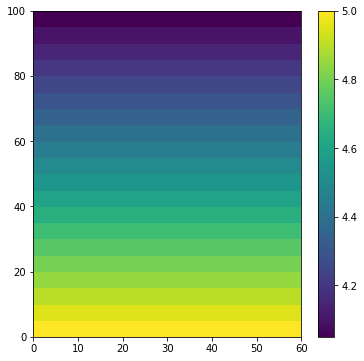

In [4]:
# add 20 vertical temperature layers
Tprof=np.linspace(5,4.05,20)    
Tprof100=np.zeros(100)+5
for zz in range(1,20):
    zini=zz*5
    Tprof100[zini:zini+5]=Tprof[zz]
# make the profile to a 3D field
Tini_field = np.zeros((nx,ny,nr))+Tprof100
Tini=Tini_field.T

plt.figure(figsize=(6,6))
cb=plt.pcolormesh(Tini[:,15,:])
plt.colorbar(cb)

(100, 40)
(100, 40, 60)
(60, 100, 40)
20ldTdy: (100, 40, 60)
<xarray.DataArray 'U_at_T_point' ()>
array(-0.01568425)
Coordinates:
    x        int64 59
(60, 100, 40)


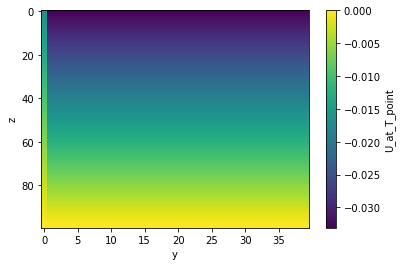

In [6]:

# add to the linear stratification a meridional gradient, but keep the meridional average as in the 20 equal layers
T_20l_dTdy=np.zeros((100,40))
print(T_20l_dTdy.shape)
for zz in range(0,100):
        #T_20l_dTdy[zz,:]=Tprof100[zz]+(Tprof100[zz]/ny)*(-19.5+Y/dy)
        T_20l_dTdy[zz,:]=Tprof100[zz]+(0.2*Tprof100[zz]/ny)*(-19.5+Y/dy)
        
T_20l_dTdy_ini=np.repeat(T_20l_dTdy[ :, :,np.newaxis], nx, axis=2)
print(T_20l_dTdy_ini.shape)
T_dTdy_3d=np.repeat(T_20l_dTdy[np.newaxis, :, :], nx, axis=0)
print(T_dTdy_3d.shape)
T_20l_dTdy_ini.astype('>f4').tofile(f'T5000_ini20l_wdTdy_tw_{len(dr)}_25km.bin')
T_dTdy_3d.astype('>f4').tofile(f'T5000_obcs20l_wdTdy_tw_{len(dr)}_25km.bin')
T_dTdy_3d=np.transpose(T_dTdy_3d,(1,2,0))

print('20ldTdy:',T_dTdy_3d.shape)
# compute pressure and density

rho=rho0- rho0*alpha0*T_dTdy_3d

ds = xr.Dataset()
ds['rho'] = (('z', 'y', 'x'), rho)
ds = ds.assign_coords(x=ds.x, y=ds.y, z=ds.z)
ds.x.attrs['axis'] = 'X'
ds.y.attrs['axis'] = 'Y'
ds.z.attrs['axis'] = 'Z'
ds = xgcm.generate_grid_ds(ds, {'X':'x', 'Y':'y', 'Z':'z'})
grid = xgcm.Grid(ds, periodic=False)
ds['dr'] = ('z', dr)
rev = -1*(g/f)*grid.cumsum(
    (
        grid.interp(1/ds.rho, 'Y', boundary='extend') * grid.diff(ds.rho, 'Y', boundary='extend') / (dy*10**3)
    ) * ds.dr,
    'Z',
    boundary='fill',
    fill_value=0
)
velocity = rev.isel(z_left=-1) - rev
ds['U_at_T_point'] = grid.interp(velocity, ['Y', 'Z'], boundary='extend')
ds['U_at_T_point'].mean('x').plot(y='z', yincrease=False)
print(ds.U_at_T_point.isel(x=59).mean(dim={'y','z'}))

U_tw=np.asarray(ds.U_at_T_point.transpose("x", "z", "y"))
print(U_tw.shape)
U_tw.astype('>f4').tofile(f'Uvel5000_tw_20lwdTdy_xzy_{len(dr)}_25km.bin') # I assume the x dimension is read as t dimension 

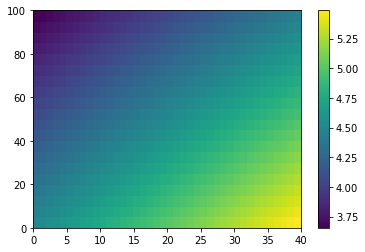

In [7]:
plt.pcolormesh(T_dTdy_3d[:,:,59])
plt.colorbar()

In [8]:
# add to the thermal wind different barotropic components
ubaro=[0.01,0.02,0.05,0.08]

for i in range (0,len(ubaro)):
    print(ubaro[i])
    U_utw=U_tw-ubaro[i]
    print(U_utw[59,:,:].mean(axis=1).mean(axis=0))
    print(U_utw.shape)
    print(np.int(ubaro[i]*100))
    U_utw.astype('>f4').tofile(f'Uvel{np.abs(np.int(H))}_u00{np.int(ubaro[i]*100)}tw_20lwdTdy_xzy_{len(dr)}_{dx}km.bin') # I assume the x dimension is read as t dimension 
    
ubaro=[0.10,0.12,0.15,0.18,0.20,0.25]

for i in range (0,len(ubaro)):
    print(ubaro[i])
    U_utw=U_tw-ubaro[i]
    print(U_utw[59,:,:].mean(axis=1).mean(axis=0))
    print(U_utw.shape)
    U_utw.astype('>f4').tofile(f'Uvel{np.abs(np.int(H))}_u0{np.int(ubaro[i]*100)}tw_20lwdTdy_xzy_{len(dr)}_{dx}km.bin') # I assume the x dimension is read as t dimension 

0.01
-0.025684251579973772
(60, 100, 40)
1
0.02
-0.035684251579973784
(60, 100, 40)
2
0.05
-0.06568425157997378
(60, 100, 40)
5
0.08
-0.09568425157997379
(60, 100, 40)
8
0.1
-0.11568425157997378
(60, 100, 40)
0.12
-0.13568425157997377
(60, 100, 40)
0.15
-0.1656842515799737
(60, 100, 40)
0.18
-0.1956842515799738
(60, 100, 40)
0.2
-0.21568425157997378
(60, 100, 40)
0.25
-0.2656842515799738
(60, 100, 40)


In [9]:
T_dTdy_3d.shape

(100, 40, 60)

3.655125

In [11]:
T_dTdy_3d[:,:,59].max()

5.4875

3.655125

In [34]:
T_dTdy_3d[:,:,59].max()-T_dTdy_3d[:,:,59].min()

1.8323749999999999

# e-scale 

(100, 40, 60)


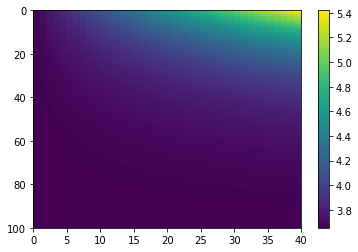

In [25]:
Tmax = T_dTdy_3d[:,:,:].max()
Tmin = T_dTdy_3d[:,:,:].min()


#Tmax = 10.
#Tmin = 1.
# 3-D Temperature field for initial conditions and RBCS northern wall profile
h = 1000             # e-folding scale for temperature decrease with depth
T_surf = np.zeros([ny, nx]) + np.reshape(
            Tmin + (Tmax-Tmin)/ny * np.linspace(0.5,39.5,ny),[ny,1]) # at (XC,YC) points
zscale = (exp(-z/h) - exp(H/h)) / (1 - exp(H/h))
zscale = np.reshape(zscale, [nr,1,1])
T_3D = np.reshape(T_surf - Tmin, [1,ny,nx]) * zscale + Tmin
print(T_3D.shape)
plt.pcolormesh(T_3D[:,:,10])
plt.colorbar()

plt.gca().invert_yaxis()


T_3D.astype('>f4').tofile(f'T{np.abs(np.int(H))}_ini_escale_{Tmin}_{Tmax}_tw_{len(dr)}_25km.bin')


In [26]:
# create boundary files for obcs with dimension t(=x),z,y
print(T_3D.shape)
Tobcstw=np.transpose(T_3D,(2,0,1))
Tobcstw.shape

Tobcstw.astype('>f4').tofile(f'T{np.abs(np.int(H))}_obcs_escale_{Tmin}_{Tmax}_tw_{len(dr)}_25km.bin')

(100, 40, 60)


(100, 40, 60)


<ipython-input-27-17d041605e4e>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(Y,z,rho[:,:,59])


Text(0, 0.5, 'Depth [m]')

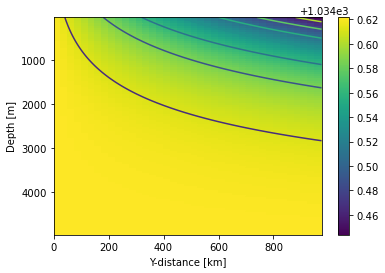

In [27]:
# compute density from T_field using a linear eos
rho=rho0- rho0*alpha0*T_3D

print(rho.shape)
plt.figure()
plt.pcolormesh(Y,z,rho[:,:,59])
plt.colorbar()
plt.contour(Y,z[:],T_3D[:,:,59])
plt.gca().invert_yaxis()
plt.xlabel('Y-distance [km]')
plt.ylabel('Depth [m]')

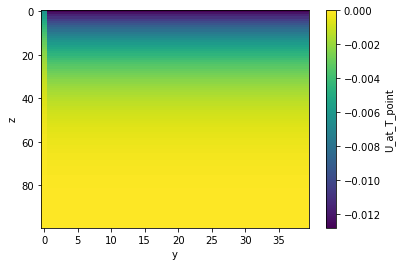

In [28]:
ds = xr.Dataset()
ds['rho'] = (('z', 'y', 'x'), rho)
ds = ds.assign_coords(x=ds.x, y=ds.y, z=ds.z)
ds.x.attrs['axis'] = 'X'
ds.y.attrs['axis'] = 'Y'
ds.z.attrs['axis'] = 'Z'
ds = xgcm.generate_grid_ds(ds, {'X':'x', 'Y':'y', 'Z':'z'})
grid = xgcm.Grid(ds, periodic=False)

ds['dr'] = ('z', dr)
rev = -1*(g/f)*grid.cumsum(
    (
        grid.interp(1/ds.rho, 'Y', boundary='extend') * grid.diff(ds.rho, 'Y', boundary='extend') / (dy*10**3)
    ) * ds.dr,
    'Z',
    boundary='fill',
    fill_value=0
)
velocity = rev.isel(z_left=-1) - rev
ds['U_at_T_point'] = grid.interp(velocity, ['Y', 'Z'], boundary='extend')
ds['U_at_T_point'].mean('x').plot(y='z', yincrease=False)
velo_rho=velocity

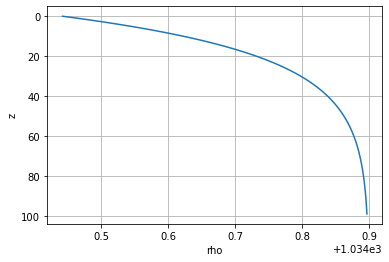

In [16]:
ds.rho.mean(dim={'x','y'}).plot(y='z')
plt.gca().invert_yaxis()
plt.grid()

In [31]:
U_tw=np.asarray(ds.U_at_T_point.transpose("x", "z", "y"))
print(U_tw.shape)
U_tw.astype('>f4').tofile(f'Uvel5000_escale_{Tmin}_{Tmax}_tw_xzy_{len(dr)}_25km.bin') # I assume the x dimension is read as t dimension 


(60, 100, 40)


In [32]:
U_u01tw=np.asarray(ds.U_at_T_point.transpose("x", "z", "y"))-0.1
print(U_u01tw.shape)
U_u01tw.astype('>f4').tofile(f'Uvel5000_escale_{Tmin}_{Tmax}_u01tw_xzy_{len(dr)}_25km.bin') # I assume the x dimension is read as t dimension 

(60, 100, 40)


<ipython-input-33-80b18caf7ea7>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(Y,z,U_u01tw[59,:,:])


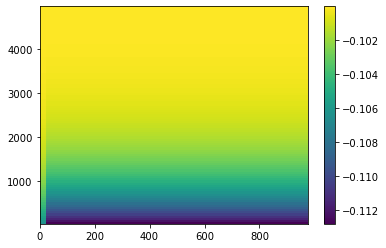

In [33]:
plt.pcolormesh(Y,z,U_u01tw[59,:,:])
plt.colorbar()